In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk

import warnings
warnings.filterwarnings('ignore')
nltk.download("stopwords") # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
nltk.download('omw-1.4') # проводит лемматизацию
stopw = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isada\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\isada\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\isada\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\isada\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
dp = pd.read_csv("labeled.csv")
dp["toxic"] = dp["toxic"].astype(np.int32)
dp.rename(columns={"toxic":"is_violent"},inplace=True)

<Axes: xlabel='is_violent', ylabel='count'>

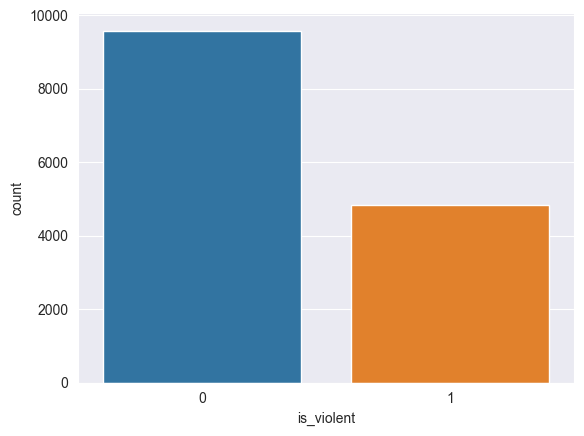

In [24]:
sns.countplot(data=dp, x="is_violent")

In [25]:
import pymorphy3
morph = pymorphy3.MorphAnalyzer()
regular_s = re.compile(r'[а-яё]+')

def tokenize(sentence:str)->list[str]:
    sentence = sentence.lower().strip()
    sentence = regular_s.findall(sentence)
    return [token for token in sentence]

def morph_stopper(list_of_tokens:list[str])->list[str]:
    return [morph.parse(word)[0].normal_form for word in list_of_tokens if len(word)>2]

def stop_words(list_of_morphs:list[str])->list[str]:
    return [word for word in list_of_morphs if word not in stopw]

def cleaner(sentence:str)->str:
    return " ".join(stop_words(morph_stopper(tokenize(sentence))))


In [26]:
dp['comment'] = dp['comment'].apply(lambda x:cleaner(x))
dp.dropna(subset='comment',inplace=True)
dp.drop_duplicates(subset='comment',inplace=True)

In [27]:
dp = dp.drop_duplicates(subset='comment')

In [28]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(dp, test_size = .33, random_state = 300,stratify=dp['is_violent'])

#Vectorize

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
# from gensim.models import Word2Vec


model_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = cleaner,ngram_range=(2, 4), analyzer='char_wb', max_df=0.8, min_df=10)),
    ('model', LogisticRegression(random_state = 0,max_iter=200))
])
model_pipeline.fit(train_data['comment'], train_data['is_violent'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char_wb', max_df=0.8, min_df=10,
                                 ngram_range=(2, 4),
                                 tokenizer=<function cleaner at 0x000001539DEE47C0>)),
                ('model', LogisticRegression(max_iter=200, random_state=0))])

In [30]:
from sklearn.metrics import precision_score, recall_score

print(f"Precision: {precision_score(test_data['is_violent'], model_pipeline.predict(test_data['comment']))}")
print(f"Recall: {recall_score(test_data['is_violent'], model_pipeline.predict(test_data['comment']))}")

Precision: 0.8957996768982229
Recall: 0.7122671804752729


Final Phase

In [33]:
from sklearn.model_selection import GridSearchCV
param_grid = {'model__C': [0.1, 1, 10.]}
grid_search= GridSearchCV(model_pipeline,param_grid,cv=5,verbose=4)
grid_search.fit(train_data.comment,train_data.is_violent)
print("Наилучшие параметры: ", grid_search.best_params_)
print("Наилучшее значение метрики: ", grid_search.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ......................model__C=0.1;, score=0.766 total time=   1.9s
[CV 2/5] END ......................model__C=0.1;, score=0.771 total time=   2.2s
[CV 3/5] END ......................model__C=0.1;, score=0.769 total time=   1.7s
[CV 4/5] END ......................model__C=0.1;, score=0.764 total time=   1.7s
[CV 5/5] END ......................model__C=0.1;, score=0.769 total time=   1.7s
[CV 1/5] END ........................model__C=1;, score=0.869 total time=   1.9s
[CV 2/5] END ........................model__C=1;, score=0.875 total time=   1.9s
[CV 3/5] END ........................model__C=1;, score=0.875 total time=   2.0s
[CV 4/5] END ........................model__C=1;, score=0.862 total time=   2.0s
[CV 5/5] END ........................model__C=1;, score=0.872 total time=   2.0s
[CV 1/5] END .....................model__C=10.0;, score=0.878 total time=   2.1s
[CV 2/5] END .....................model__C=10.0;,

In [34]:
best_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = cleaner,ngram_range=(2, 4), analyzer='char_wb', max_df=0.8, min_df=10)),
    ('model', LogisticRegression(random_state = 0,C=10,max_iter=200))
])
best_pipe.fit(train_data['comment'], train_data['is_violent'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char_wb', max_df=0.8, min_df=10,
                                 ngram_range=(2, 4),
                                 tokenizer=<function cleaner at 0x000001539DEE47C0>)),
                ('model',
                 LogisticRegression(C=10, max_iter=200, random_state=0))])

In [35]:
best_pipe.score(test_data['comment'],test_data['is_violent'])

0.8874356775300172

In [36]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresholds = precision_recall_curve(test_data['is_violent'], best_pipe.predict_proba(test_data['comment'])[:, 1])
np.where(prec > 0.95)

(array([3818, 3819, 3820, 3821, 3822, 3823, 3839, 3840, 3841, 3842, 3843,
        3860, 3861, 3862, 3863, 3867, 3868, 3869, 3870, 3871, 3872, 3873,
        3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3898,
        3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909,
        3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920,
        3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930, 3931,
        3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940, 3941, 3942,
        3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953,
        3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964,
        3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975,
        3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986,
        3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997,
        3998, 3999, 4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008,
        4009, 4010, 4011, 4012, 4013, 

In [43]:
trash_talk_coef = thresholds[3818]
print(f"Precision: {precision_score(test_data['is_violent'], best_pipe.predict_proba(test_data['comment'])[:, 1] > trash_talk_coef)}")
print(f"Recall: {recall_score(test_data['is_violent'], best_pipe.predict_proba(test_data['comment'])[:, 1] > trash_talk_coef)}")

Precision: 0.9502958579881656
Recall: 0.5157353885677585


In [44]:
print(thresholds[3818])

0.8517369429054353


In [39]:
import joblib
joblib.dump(best_pipe, 'final_model.joblib')

['final_model.joblib']